In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from skimage.feature import hog
%matplotlib inline



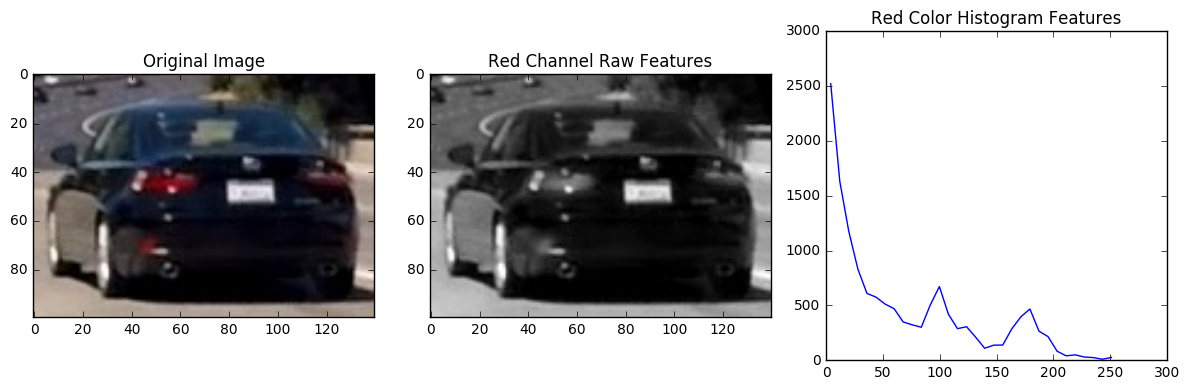

In [2]:

# Read in test image
image = mpimg.imread('./test_images/test1.jpg')
cutout = image[400:500, 810:950]    # Black Car 
#cutout = image[400:510, 1050:1270]   # White Car

bins_range = (0,255)
red= cutout[:,:,0]
rhist = np.histogram(red, bins = 32, range=bins_range, normed = False )
bin_edges = rhist[1]
bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
#print(rhist[0], bin_centers)
# Plot an example of cutout raw image, red channel image and histogram features
fig = plt.figure(figsize=(12,4))
plt.subplot(131)
plt.imshow(cutout)
plt.title('Original Image')
plt.subplot(132)
plt.imshow(red, cmap = 'gray')
plt.title('Red Channel Raw Features')
plt.subplot(133)
plt.plot(bin_centers, rhist[0])
plt.title('Red Color Histogram Features')
fig.tight_layout()


In [3]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

In [4]:
# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features


In [5]:
def extract_features(imgs, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256)):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        # Append the new feature vector to the features list
        features.append(np.concatenate((spatial_features, hist_features)))
    # Return list of feature vectors
    return features

In [6]:
# Read in car and non-car images
cars = glob.glob('./vehicles/*/*.png')
notcars = glob.glob('./non-vehicles/*/*.png')

In [7]:
car_features_YCrCb = extract_features(cars, cspace='YCrCb', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256))
notcar_features_YCrCb = extract_features(notcars, cspace='YCrCb', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256))


In [8]:
car_features_RGB = extract_features(cars, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256))
notcar_features_RGB = extract_features(notcars, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256))


In [9]:
def hist(hist, bins = 32, range=bins_range, normed = False  ):
    X_hist = np.histogram(hist, bins = 32, range=bins_range, normed = False )
    bin_edges = X_hist[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
    return X_hist, bin_centers

3168


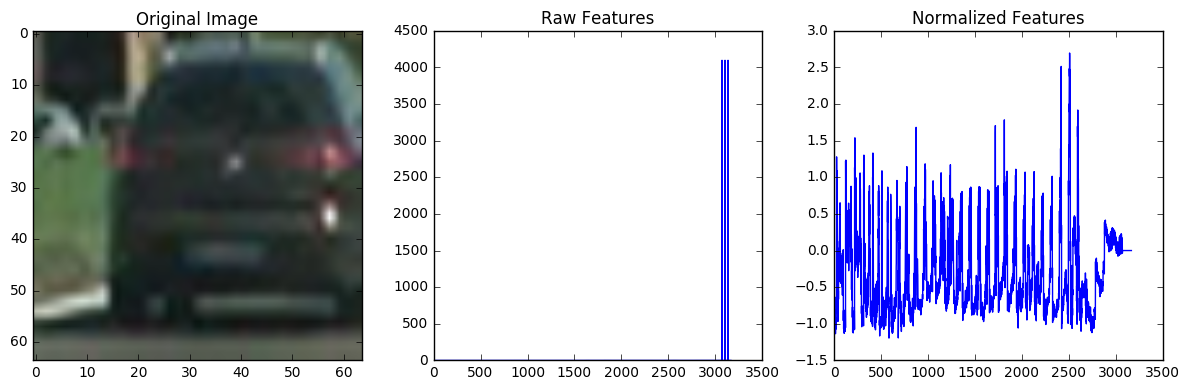

In [10]:
if len(car_features_RGB) > 0:
    # Create an array stack of feature vectors
    X = np.vstack((car_features_RGB, notcar_features_RGB)).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
    print(len(scaled_X[0]))
    car_ind = np.random.randint(0, len(cars))
    
    #X_hist, bin_centers = np.histogram(scaled_X, bins = 32, range=bins_range, normed = False )
    # Plot an example of raw and scaled features
    fig = plt.figure(figsize=(12,4))
    plt.subplot(131)
    plt.imshow(mpimg.imread(cars[car_ind]))
    plt.title('Original Image')
    plt.subplot(132)
    plt.plot(X[car_ind])
    plt.title('Raw Features')
    plt.subplot(133)
    plt.plot(scaled_X[car_ind])
    #plt.plot(hist(scaled_X[car_ind]))
    plt.title('Normalized Features')
    fig.tight_layout()
else: 
    print('Your function only returns empty feature vectors...')

3168


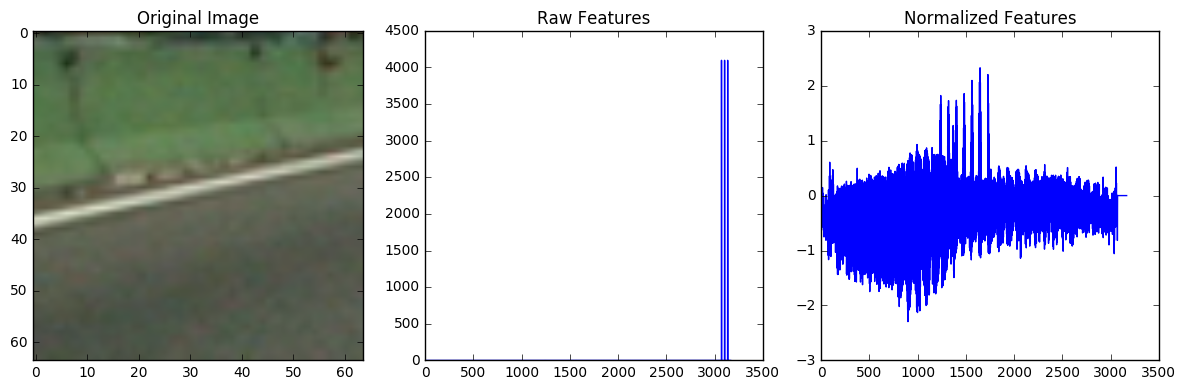

In [11]:
if len(car_features_YCrCb) > 0:
    # Create an array stack of feature vectors
    X = np.vstack((car_features_YCrCb, notcar_features_YCrCb)).astype(np.float64) 
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
    print(len(scaled_X[0]))
    index = np.random.randint(0, len(notcars))+len(cars)
    
    #X_hist, bin_centers = np.histogram(scaled_X, bins = 32, range=bins_range, normed = False )
    # Plot an example of raw and scaled features
    fig = plt.figure(figsize=(12,4))
    plt.subplot(131)
    plt.imshow(mpimg.imread(notcars[index-len(cars)]))
    plt.title('Original Image')
    plt.subplot(132)
    plt.plot(X[index])
    plt.title('Raw Features')
    plt.subplot(133)
    plt.plot(scaled_X[index])
    #plt.plot(hist(scaled_X[car_ind]))
    plt.title('Normalized Features')
    fig.tight_layout()
else: 
    print('Your function only returns empty feature vectors...')

In [12]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

In [13]:
def extract_hog_features(imgs, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(hog_features)
    # Return list of feature vectors
    return features

In [14]:
sample_size = 8000
cars = cars[0:sample_size]
notcars = notcars[0:sample_size]

### TODO: Tweak these parameters and see how the results change.
colorspace = 'RGB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 0 # Can be 0, 1, 2, or "ALL"

t=time.time()
car_features = extract_hog_features(cars, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
notcar_features = extract_hog_features(notcars, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

37.76 Seconds to extract HOG features...
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 1764
11.68 Seconds to train SVC...
Test Accuracy of SVC =  0.9391
My SVC predicts:  [ 1.  0.  0.  0.  1.  1.  1.  0.  1.  0.]
For these 10 labels:  [ 1.  0.  0.  0.  1.  1.  1.  0.  1.  0.]
0.00405 Seconds to predict 10 labels with SVC


In [15]:
train_acc = svc.score(X_train,y_train)
test_acc = svc.score(X_test,y_test)
print('Training accuracy: ',train_acc)
print('Testing accuracy: ',test_acc)

Training accuracy:  0.999765625
Testing accuracy:  0.9390625


In [102]:
# Testing the svc prediction(car, car, notcar) 
test = ['11.png','image0009.png','image10.png','11.png','image0009.png','image10.png']
t=time.time()
test_feature = extract_hog_features(test, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
scaled_test = X_scaler.transform(test_feature)
print(len(scaled_test[1]))
t2=time.time()
print(svc.predict(scaled_test), round(t2-t, 5))

1764
[ 1.  1.  0.  1.  1.  0.] 0.01724


In [17]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

In [18]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_windows = np.int(xspan/nx_pix_per_step) - 1
    ny_windows = np.int(yspan/ny_pix_per_step) - 1
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append((startx, starty), (endx, endy))
    # Return the list of windows
    return window_list


27
[((640, 412), (704, 476)), ((768, 412), (832, 476)), ((704, 380), (768, 444)), ((128, 412), (192, 476)), ((224, 412), (288, 476)), ((832, 380), (896, 444)), ((0, 380), (64, 444)), ((416, 412), (480, 476)), ((576, 380), (640, 444)), ((960, 412), (1024, 476)), ((864, 412), (928, 476)), ((992, 380), (1056, 444)), ((584, 400), (712, 500)), ((552, 400), (680, 500)), ((552, 400), (680, 500)), ((1032, 400), (1160, 500)), ((392, 400), (520, 500)), ((744, 400), (872, 500)), ((552, 400), (680, 500)), ((872, 400), (1000, 500)), ((360, 400), (488, 500)), ((648, 400), (776, 500)), ((310, 500), (560, 660)), ((496, 420), (746, 580)), ((248, 500), (498, 660)), ((1054, 420), (1304, 580)), ((372, 500), (622, 660))]


<function matplotlib.pyplot.show>

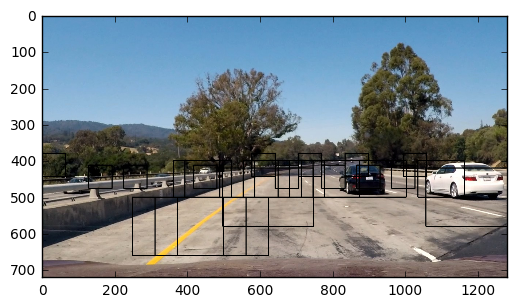

In [160]:
def random_scan_boxes(image, far = 10, mid = 5, near = 3):
    #Create a list to append scan window coordinates
    scan_windows = []
    w_far = slide_window(image, x_start_stop=[None, None], y_start_stop=[380, 500], 
                    xy_window=(64,64), xy_overlap=(0.5, 0.5))
    for i in range (far):
        f = np.random.randint(0, len(w_far))
        scan_windows.append(w_far[f])
        #window_img = draw_boxes(image, windows, color=(0, 255, 255), thick=6)                    

    w_mid = slide_window(image, x_start_stop=[200, 1100], y_start_stop=[400, 550], 
                    xy_window=(128,100), xy_overlap=(0.75, 0.3))
    for i in range (mid):
        m = np.random.randint(0, len(w_mid))
        scan_windows.append(w_mid[m])
    
        #window_m_img = draw_boxes(window_img, window_m, color=(255, 255, 255), thick=6)                    

    w_near = slide_window(image, x_start_stop=[None, None], y_start_stop=[420, 700], 
                    xy_window=(250,160), xy_overlap=(0.75, 0.5))
    for i in range (near):
        n = np.random.randint(0, len(w_near))
        scan_windows.append(w_near[n])
        
    return scan_windows

image = mpimg.imread('./test_images/test1.jpg').astype(np.float32)/255
boxes = random_scan_boxes(image, far = 12, mid = 10, near = 5)
window_img = draw_boxes(image, boxes, color=(0, 0, 0), thick=2)                    

print(len(boxes))
print(boxes)


#plt.imshow(window_img)
plt.imshow(window_img)
plt.show

In [148]:
def single_img_features(image, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    
    # Resize to (64, 64)
    #image = cv2.resize(image,(64,64))
    # apply color conversion if other than 'RGB'
    if cspace != 'RGB':
        if cspace == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(image)      

    # Call get_hog_features() with vis=False, feature_vec=True
    if hog_channel == 'ALL':
        hog_features = []
        for channel in range(feature_image.shape[2]):
            hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                                 orient, pix_per_cell, cell_per_block, 
                                                 vis=False, feature_vec=True))
        hog_features = np.ravel(hog_features)        
    else:
        hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
    # Append the new feature vector to the features list
    features.append(hog_features)
    # Return list of feature vectors
    return features


In [107]:
# Testing the svc prediction(car, car, notcar) 
test = ['11.png','image0009.png','image10.png']

t=time.time()
for file in test:
    # Read in each one by one
    image = mpimg.imread(file)
    
    test_feature = single_img_features(image, cspace='RGB', orient=9, pix_per_cell=8,\
                                       cell_per_block=2, hog_channel=0)
    scaled_test = X_scaler.transform(test_feature)
    print(len(scaled_test[0]))
    print(svc.predict(scaled_test))
t2=time.time()
print(round(t2-t, 5))

1764
[ 1.]
1764
[ 1.]
1764
[ 0.]
0.01047


5.2 fps
10


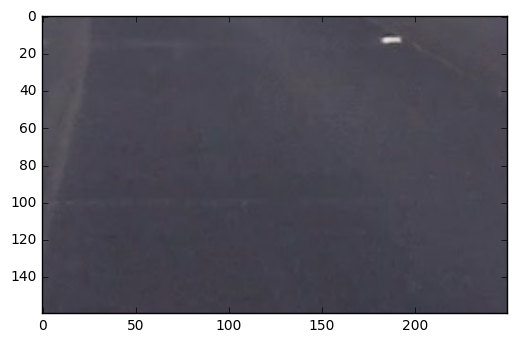

In [266]:
t=time.time()
image = mpimg.imread('./test_images/test3.jpg').astype(np.float32)/255
t=time.time()
boxes = random_scan_boxes(image, far = 40, mid = 20, near = 5)
find_car_img = []
find_car_boxes = []
for box in boxes:
    #print (box[0], box[0][0],box[0][1],box[1][0], box[1][1])
    x1,y1,x2,y2 = box[0][0],box[0][1],box[1][0], box[1][1]
    
    crop = image[y1:y2,x1:x2]  #Normalize .jpg image from 0-255 to 0-1

    test_feature = single_img_features(cv2.resize(crop, (64,64)), cspace='RGB', \
                                   orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0)

    scaled_test = X_scaler.transform(test_feature)

    if svc.predict(scaled_test) == 1:
        find_car_img.append(crop)
        find_car_boxes.append(box)
        plt.imshow(crop)
t2=time.time()
print(round(1/(t2-t), 1), 'fps')
print (len(find_car))

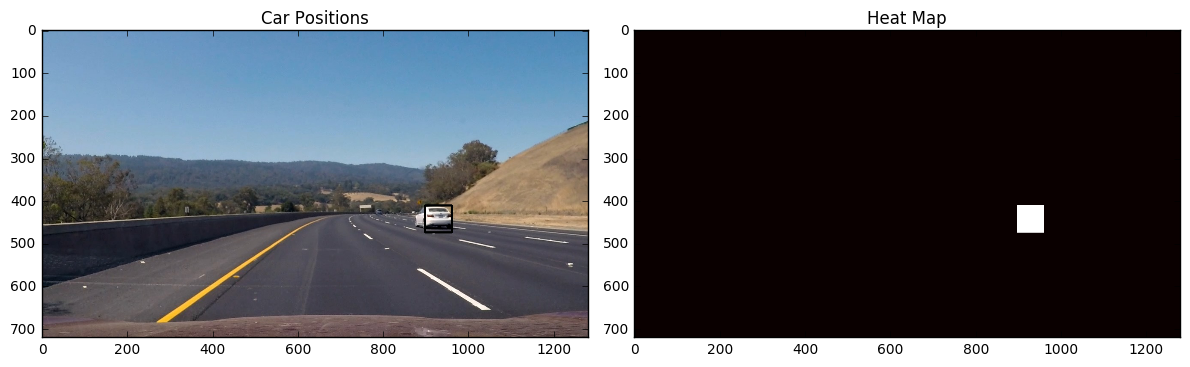

In [267]:
# Read in image similar to one shown above 
#image = mpimg.imread('test_image.jpg')
heat = np.zeros_like(image[:,:,0]).astype(np.float)

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,255,255), 4)
    # Return the image
    return img

# Add heat to each box in box list
heat = add_heat(heat,find_car_boxes)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

from scipy.ndimage.measurements import label
# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(image), labels)
fig = plt.figure(figsize=(12,5))
#fig = plt.figure(12,5)
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()

In [ ]:
for ch in range(car.shape[2]):
    f,(ax1,ax2,ax3,ax4) = plt.subplots(1,4,figsize = (15,20))
    _,hog_car = get_hog_features(car[:,:,ch],vis = True , feature_vec = True)
    _,hog_nocar = get_hog_features(nocar[:,:,ch],vis = True , feature_vec = True)

    ax1.imshow(car[:,:,ch],cmap = 'gray')
    ax2.imshow(hog_car , cmap ='gray')
    ax3.imshow(nocar[:,:,ch],cmap = 'gray')
    ax4.imshow(hog_nocar , cmap ='gray')
    ax1.set_title('Car channel ' +str(ch))
    ax2.set_title('Channel '+str(ch)+' Hog')
    ax3.set_title('Not Car channel ' +str(ch))
    ax4.set_title('Not Car Channel '+str(ch)+' Hog')

    plt.show()

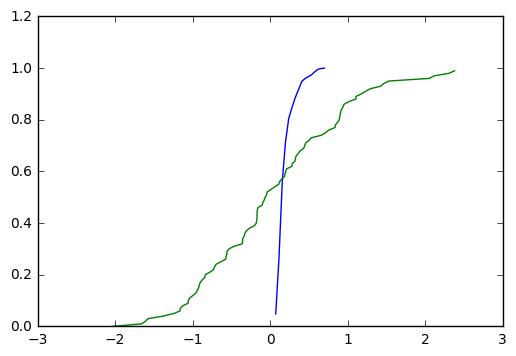

In [44]:
N = 100
Z = np.random.normal(size = N)
# method 1
#H,X1 = np.histogram( Z, bins = 12, normed = True )
dx = X1[1] - X1[0]
F1 = np.cumsum(H)*dx
#method 2
X2 = np.sort(Z)
F2 = np.array(range(N))/float(N)

plt.plot(X1[1:], F1)
plt.plot(X2, F2)
plt.show()

[ 0.00233004  0.00680738  0.0198739   0.02046784  0.02453399  0.03047332
  0.01631031  0.0127924   0.01087354  0.00616776  0.00310673  0.00479715
  0.00452303  0.00260417  0.0031981   0.00260417  0.00347222  0.00246711
  0.00132493  0.00082237  0.00091374  0.00045687  0.00031981  0.00100512
  0.00150768  0.00068531  0.00109649  0.00077668  0.00018275  0.00031981
  0.00018275  0.00013706] [   8.        13.34375   18.6875    24.03125   29.375     34.71875
   40.0625    45.40625   50.75      56.09375   61.4375    66.78125   72.125
   77.46875   82.8125    88.15625   93.5       98.84375  104.1875
  109.53125  114.875    120.21875  125.5625   130.90625  136.25     141.59375
  146.9375   152.28125  157.625    162.96875  168.3125   173.65625  179.     ]


ValueError: x and y must have same first dimension

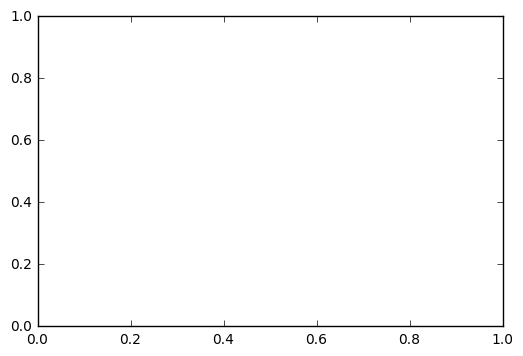

In [32]:
print(H,X1)
plt.plot(X1, H)
plt.show

[0 2 4 1 2 1 1 2 1 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118

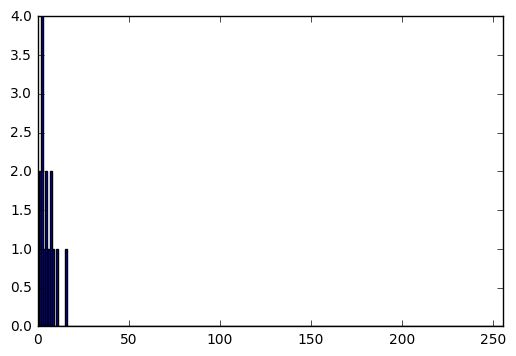

In [24]:
import numpy as np    
hist, bin_edges = np.histogram([1, 1, 2, 2, 2, 2, 3,4,4,5,7,6,7,8, 10,15], bins = range(256))

#Below, hist indicates that there are 0 items in bin #0, 2 in bin #1, 4 in bin #3, 1 in bin #4.

print(hist)
# array([0, 2, 4, 1])   

#bin_edges indicates that bin #0 is the interval [0,1), bin #1 is [1,2), ..., bin #3 is [3,4).

print (bin_edges)
# array([0, 1, 2, 3, 4]))  

#Play with the above code, change the input to np.histogram and see how it works.

#But a picture is worth a thousand words:

import matplotlib.pyplot as plt
plt.bar(bin_edges[:-1], hist, width = 1)
plt.xlim(min(bin_edges), max(bin_edges))
plt.show()   